### Getting the Main Functions Working (Pre-Operation)
1. get_edges(polygon); turn edges of polygons into lines w/ parametric form
2. edge_intersection(e1, e2, eps=1e-9); Using the formula from the PPT (parametric equation, solve for t, if meet requirement then intersection point)
3. segment_edge(edge, intersection_points); Segment , using eucledian distance to sort points so that it can segment clearer
4. polygon_intersections(poly1, poly2); Find Segments in each  FROM POLY1 AND POLY2 based on intersection points, 
5. Check_inside(segments); Midpoint of each Segment, use infinitely long line. If odd in, even out


![Alt text](./triangle.png)

In [67]:
#Testing Polygons: Two Triangles Puncturing Two of its three Edges.
A = [(-149.0, 236.0), (-310.0, -75.0), (28.0, -58.0)]
B = [(61.0, 206.0), (-215.0, -148.0), (255.0, 97.0)]

In [68]:
#Display the Polygons
import turtle as T

T.hideturtle()
Sc = T.Screen()

def display(poly):
    T.pu()                # pen up          
    T.goto(poly[0])     # go to first point
    T.pd()                # pen down
    for p in poly[1:]:
        T.goto(p)
    T.goto(poly[0])     # Close Poly
    T.update()          # Update   

display(A)
display(B)
T.done()

In [69]:
#Function to turn each Edge of Polygon into ((x1, y1), (x2, y2))
def get_edges(poly):
    edges = []
    n = len(poly)
    for i in range(n):
        x = poly[i]
        y = poly[(i + 1) % n] # wrap around
        edges.append((x, y))
    return edges


#Debug Purposes, shld display three for each
edges_poly1 = get_edges(A)
edges_poly2 = get_edges(B)
print(edges_poly1)
print(edges_poly2)

[((-149.0, 236.0), (-310.0, -75.0)), ((-310.0, -75.0), (28.0, -58.0)), ((28.0, -58.0), (-149.0, 236.0))]
[((61.0, 206.0), (-215.0, -148.0)), ((-215.0, -148.0), (255.0, 97.0)), ((255.0, 97.0), (61.0, 206.0))]


In [70]:
'''
Each edge of the polygon is ((xi1, yi1), (xi2, yi2))
i is the polygon number, where i = 1 refers to polygon number 1, i = 2 polygon number 2 etc. 
By having two distinct points, we can turn it into parametric equation, where
- V (direction vector) is from xi2-xi1 and yi2-yi1 from same polygon
- t1 = ((A2xV2y – A2yV2x) – (A1xV2y – A1yV2x)) / (V1xV2y – V1yV2x) 
- t2 = ((A2xV1y – A2yV1x) – (A1xV1y – A1yV1x)) / (V1xV2y – V1yV2x)
- Check values, if both t1 t2  >= 0 and <= 1 then intersection point.
- Hence this function is meant to take in each one pair of edges. Implemented using a nested loop so it can cycle through all possible edge combinations between two polygons 
'''
def edge_intersections(e1, e2, eps=1e-9):
    (x11, y11), (x12, y12) = e1  # e1(P11, P12)
    (x21, y21), (x22, y22) = e2  # e2(P21, P22)
    
    #Direction Vectors
    v1x, v1y = x12-x11, y12-y11
    v2x, v2y = x22-x21, y22-y21
    
    #Denominator & Error Handling
    denominator = (v1x*v2y - v1y*v2x)
    if abs(denominator) < eps:
        print("Denominator is Approximately Zero. Lines are Parallel/Colinear")
    
    #If not parallel then can calculate
    t1 = ((x21 * v2y - y21 * v2x) - (x11 * v2y - y11 * v2x)) / denominator
    t2 = ((x21 * v1y - y21 * v1x) - (x11 * v1y - y11 * v1x)) / denominator
    
    #Check if t values satisfy condition for intersection
    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        ix = x11 + v1x * t1 #x11 is starting point, v1x is x-length * t, where t is a "percentage" of the line
        iy = y11 + v1y * t1
        return (ix, iy)  # intersection point
    else:
        return None
    
#Example
print(edge_intersections(e1[1], e2[2]))

None


In [71]:
'''
Now that the Edge has been identified along with its intersection pointsn
Need to divide the edge into sections based on the intersection points
This function segments takes in the edge of ONE polygon and its subsequent intersection points
To make sure that its dividing by the correct points, it should divide by the closest points based on eucledian distance
'''

def to_segment(edge, intersect_points):
    #Each Singular Edge is Edge (P1, P2)
    (x1, y1), (x2, y2) = edge
    
    all_points = [(x1, y1)] + intersect_points + [(x2, y2)]
    
    def euclid_dist_from_ref(p, p_ref=(x1, y1)):
        (px, py) = p #point being tested
        (x, y) = p_ref #reference point
        return ((px - x)**2 + (py - y)**2)**0.5 
    
    all_points.sort(key=euclid_dist_from_ref)
    
    #A segment, just like edge is Segment((x1,y1), (x2, y2)), so Just need to append the sorted points
    segments = []
    for i in range(len(all_points) - 1):
        segments.append((all_points[i], all_points[i+1]))
    return segments
    

In [72]:
def intersection_check(e1, e2, eps=1e-9):
    '''
    Each edge is ((x11, y11), (x12, y12))
    '''
    
    (x11, y11), (x12, y12) = e1  # Edge 1 endpoints: P11, P12
    (x21, y21), (x22, y22) = e2  # Edge 2 endpoints: P21, P22
    
     # Direction vectors V1 = P12 - P11, V2 = P22 - P21
    v1x, v1y = x12 - x11, y12 - y11
    v2x, v2y = x22 - x21, y22 - y21
    
    denominator = v1x * v2y - v1y * v2x
    
    #Parallel case
    if abs(denominator) < eps: 
        return None
    
    # Numerators from Appendix B (Eqns 5 and 6)
    # A1 = (x11, y11), A2 = (x21, y21)
    t1 = ((x21 * v2y - y21 * v2x) - (x11 * v2y - y11 * v2x)) / denominator
    t2 = ((x21 * v1y - y21 * v1x) - (x11 * v1y - y11 * v1x)) / denominator

    # Check if intersection lies within both segments (0 <= t <= 1)
    if 0 <= t1 <= 1 and 0 <= t2 <= 1:
        ix = x11 + v1x * t1
        iy = y11 + v1y * t1
        return (ix, iy)  # intersection point
    else:
        return None
    
intersection_check
    

<function __main__.intersection_check(e1, e2, eps=1e-09)>

In [92]:
#Main Function
def pre_process_polygon(poly1, poly2):
    #get the edges of both polygons
    edges_poly1 = get_edges(poly1)
    edges_poly2 = get_edges(poly2)
    
    #Intersections per Polygon
    intersections_on_poly1 = [[] for _ in range(len(edges_poly1))]
    intersections_on_poly2 = [[] for _ in range(len(edges_poly2))]
    intersections = []
    
    for i in range(len(edges_poly1)):
        for j in range(len(edges_poly2)):
            p = intersection_check(edges_poly1[i], edges_poly2[j])
            if p is not None:
                intersections_on_poly1[i].append(p) #i 
                intersections_on_poly2[j].append(p) #j correspond to the edge-index
                intersections.append(p)

    segments_poly1 = []
    for i in range(len(edges_poly1)):
        segments_poly1.append(to_segment(edges_poly1[i], intersections_on_poly1[i]))
    segments_poly2 = []
    for i in range(len(edges_poly2)):
        segments_poly2.append(to_segment(edges_poly2[i], intersections_on_poly2[i]))

    return segments_poly1, segments_poly2, intersections
 
segments_poly1, segments_poly2, intersections = pre_process_polygon(A, B)

print("=== Polygon A Segmented Edges ===")
print(segments_poly1)
print("\n=== Polygon B Segmented Edges ===")
print(segments_poly2)
print("\n=== Intersection Points ===")
print(intersections)



=== Polygon A Segmented Edges ===
[[((-149.0, 236.0), (-310.0, -75.0))], [((-310.0, -75.0), (-151.88444676409188, -67.04744258872651)), ((-151.88444676409188, -67.04744258872651), (-49.85926222935046, -61.91599839615076)), ((-49.85926222935046, -61.91599839615076), (28.0, -58.0))], [((28.0, -58.0), (11.196480211517805, -30.089068825910932)), ((11.196480211517805, -30.089068825910932), (-47.30642132932782, 67.08524220803605)), ((-47.30642132932782, 67.08524220803605), (-149.0, 236.0))]]

=== Polygon B Segmented Edges ===
[[((61.0, 206.0), (-47.30642132932782, 67.08524220803605)), ((-47.30642132932782, 67.08524220803605), (-151.88444676409188, -67.04744258872651)), ((-151.88444676409188, -67.04744258872651), (-215.0, -148.0))], [((-215.0, -148.0), (-49.85926222935046, -61.91599839615076)), ((-49.85926222935046, -61.91599839615076), (11.196480211517805, -30.089068825910932)), ((11.196480211517805, -30.089068825910932), (255.0, 97.0))], [((255.0, 97.0), (61.0, 206.0))]]

=== Intersection P

In [138]:
'''
After defining segments from the intersection points
Take Midpoint of each segment and then use an infinitely long line
This function takes in JUST a segment
'''
def insideout_check(segments, other_poly):
    #Identify Reference point (midpoint)
    results = []
    counts = []
    for i in range(len(segments)):
        results_per_edge = []
        count_per_edge = []
        for j in range(len(segments[i])):
            #Because the way these points are structured, need two four loops. One to iterate between edges, another between segments
            segment = segments[i][j]        #i for edges, j for segments within a specific edge
            (x1, y1), (x2, y2) = segment
            print("Segment:", segment)
            #Reference from Midpoint P = A + Vt
            
            #Given/Reference Point (mid_x, mid_y)
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            A = (mid_x, mid_y)
            v = (1, 0)  #horizontal
            
            #Find Random End Point P
            px = mid_x + 1 * 1e6
            py = mid_y + 0 * 1e6
            P = (px, py)
            
            #The infinite line as a "edge"
            line_edge = (A, P)
            print(line_edge)
            
            #count
            count = 0
            other_edges = get_edges(other_poly)
            for other_edge in other_edges:
                (x1, y1), (x2, y2) = other_edge
                print("Other Poly:", other_edge)
                if intersection_check(line_edge, other_edge) is not None: 
                    count += 1
                    print(f"Intersection Found in {other_edge}")


            io_check = count % 2 == 1
            # results.append(io_check)
            results_per_edge.append(io_check)
            count_per_edge.append(count)
        counts.append(count_per_edge)
        results.append(results_per_edge)
        
    return counts, results

In [139]:
counts, insideout_results = insideout_check(segments_poly1, B)
print(counts)
print(insideout_results)

Segment: ((-149.0, 236.0), (-310.0, -75.0))
((-229.5, 80.5), (999770.5, 80.5))
Other Poly: ((61.0, 206.0), (-215.0, -148.0))
Intersection Found in ((61.0, 206.0), (-215.0, -148.0))
Other Poly: ((-215.0, -148.0), (255.0, 97.0))
Intersection Found in ((-215.0, -148.0), (255.0, 97.0))
Other Poly: ((255.0, 97.0), (61.0, 206.0))
Segment: ((-310.0, -75.0), (-151.88444676409188, -67.04744258872651))
((-230.94222338204594, -71.02372129436326), (999769.0577766179, -71.02372129436326))
Other Poly: ((61.0, 206.0), (-215.0, -148.0))
Intersection Found in ((61.0, 206.0), (-215.0, -148.0))
Other Poly: ((-215.0, -148.0), (255.0, 97.0))
Intersection Found in ((-215.0, -148.0), (255.0, 97.0))
Other Poly: ((255.0, 97.0), (61.0, 206.0))
Segment: ((-151.88444676409188, -67.04744258872651), (-49.85926222935046, -61.91599839615076))
((-100.87185449672117, -64.48172049243864), (999899.1281455032, -64.48172049243864))
Other Poly: ((61.0, 206.0), (-215.0, -148.0))
Other Poly: ((-215.0, -148.0), (255.0, 97.0))


In [ ]:
[[((-149.0, 236.0), (-310.0, -75.0))], 
 [((-310.0, -75.0), (-151.88444676409188, -67.04744258872651)), ((-151.88444676409188, -67.04744258872651), (-49.85926222935046, -61.91599839615076)), ((-49.85926222935046, -61.91599839615076), (28.0, -58.0))], 
 [((28.0, -58.0), (11.196480211517805, -30.089068825910932)), ((11.196480211517805, -30.089068825910932), (-47.30642132932782, 67.08524220803605)), ((-47.30642132932782, 67.08524220803605), (-149.0, 236.0))]]


# For Debug

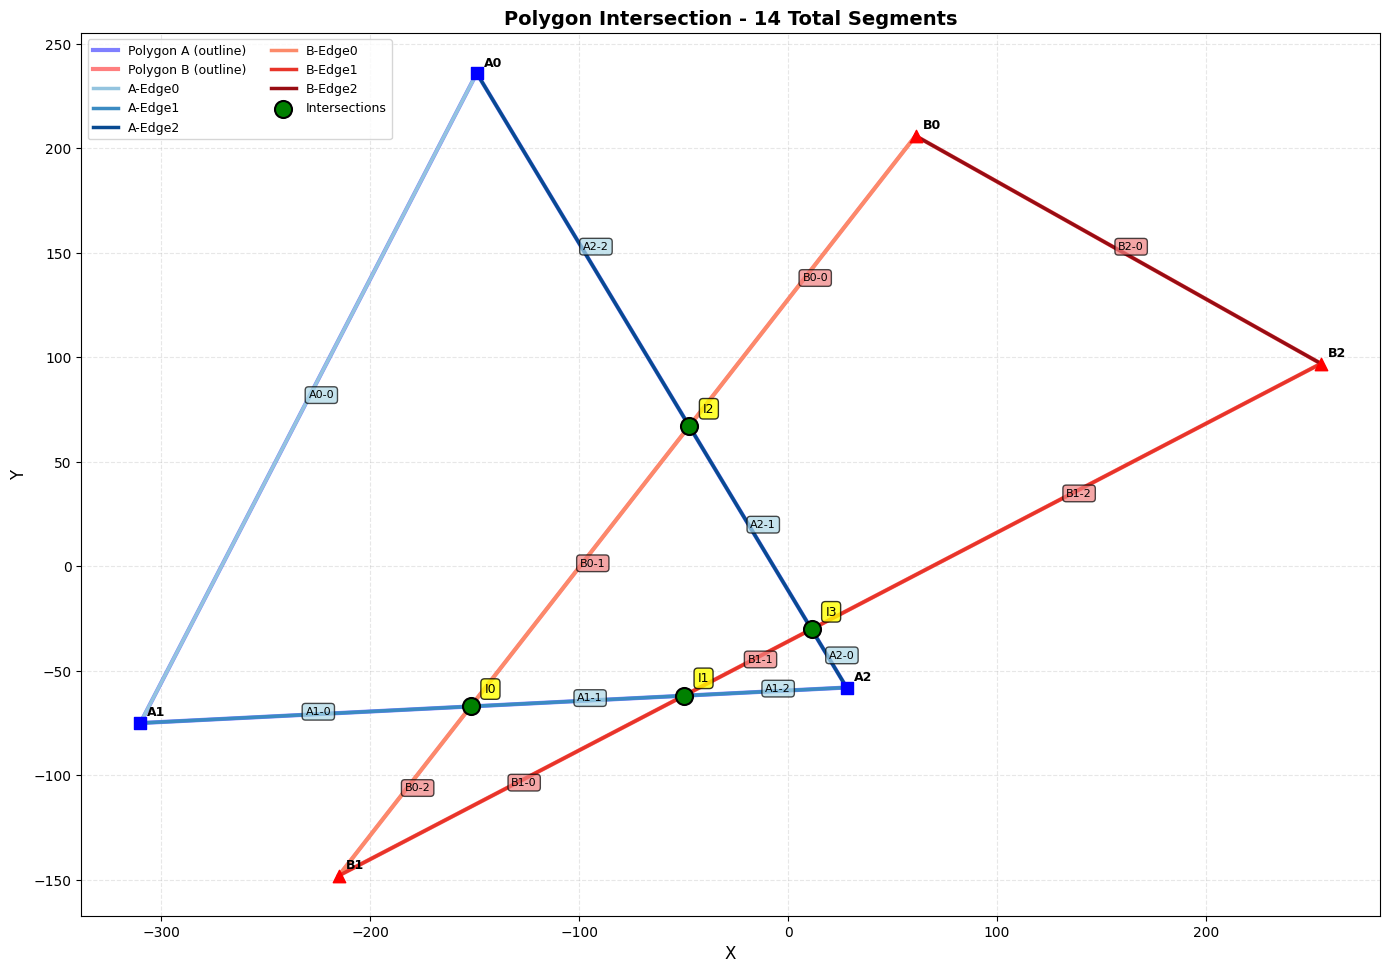

In [ ]:
#This is just for debugging purposes to visualize the segments and intersections NOT USING TURTLE, NOT TESTED
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

def visualize_polygon_intersection_colored(poly1, poly2, seg1, seg2, intersections):
    """
    Visualize the two polygons with segments in different colors and labels
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Draw original polygon outlines
    poly1_x = [p[0] for p in poly1] + [poly1[0][0]]
    poly1_y = [p[1] for p in poly1] + [poly1[0][1]]
    ax.plot(poly1_x, poly1_y, 'b-', linewidth=3, label='Polygon A (outline)', alpha=0.5)
    
    poly2_x = [p[0] for p in poly2] + [poly2[0][0]]
    poly2_y = [p[1] for p in poly2] + [poly2[0][1]]
    ax.plot(poly2_x, poly2_y, 'r-', linewidth=3, label='Polygon B (outline)', alpha=0.5)
    
    # Color palette for segments
    colors_a = plt.cm.Blues(np.linspace(0.4, 0.9, len(seg1)))
    colors_b = plt.cm.Reds(np.linspace(0.4, 0.9, len(seg2)))
    
    segment_count = 0
    
    # Draw segmented edges for Polygon A with different colors and labels
    for edge_idx, edge_segments in enumerate(seg1):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_a[edge_idx], linewidth=2.5, 
                   label=f'A-Edge{edge_idx}' if seg_idx == 0 else '')
            
            # Label segment with midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            ax.annotate(f'A{edge_idx}-{seg_idx}', 
                       xy=(mid_x, mid_y), fontsize=8, 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
            segment_count += 1
    
    # Draw segmented edges for Polygon B with different colors and labels
    for edge_idx, edge_segments in enumerate(seg2):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_b[edge_idx], linewidth=2.5, 
                   label=f'B-Edge{edge_idx}' if seg_idx == 0 else '')
            
            # Label segment with midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            ax.annotate(f'B{edge_idx}-{seg_idx}', 
                       xy=(mid_x, mid_y), fontsize=8, 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
            segment_count += 1
    
    # Draw intersection points
    if intersections:
        int_x = [p[0] for p in intersections]
        int_y = [p[1] for p in intersections]
        ax.scatter(int_x, int_y, c='green', s=150, zorder=5, 
                  label='Intersections', marker='o', edgecolors='black', linewidth=1.5)
        
        # Label intersection points
        for i, (x, y) in enumerate(intersections):
            ax.annotate(f'I{i}', 
                       xy=(x, y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # Draw polygon vertices
    for i, p in enumerate(poly1):
        ax.scatter(p[0], p[1], c='blue', s=80, zorder=4, marker='s')
        ax.annotate(f'A{i}', xy=p, xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')
    
    for i, p in enumerate(poly2):
        ax.scatter(p[0], p[1], c='red', s=80, zorder=4, marker='^')
        ax.annotate(f'B{i}', xy=p, xytext=(5, 5), textcoords='offset points', fontsize=9, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=9, ncol=2)
    ax.set_title(f'Polygon Intersection - {segment_count} Total Segments', fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_polygon_intersection_colored(A, B, seg1, seg2, intersections)

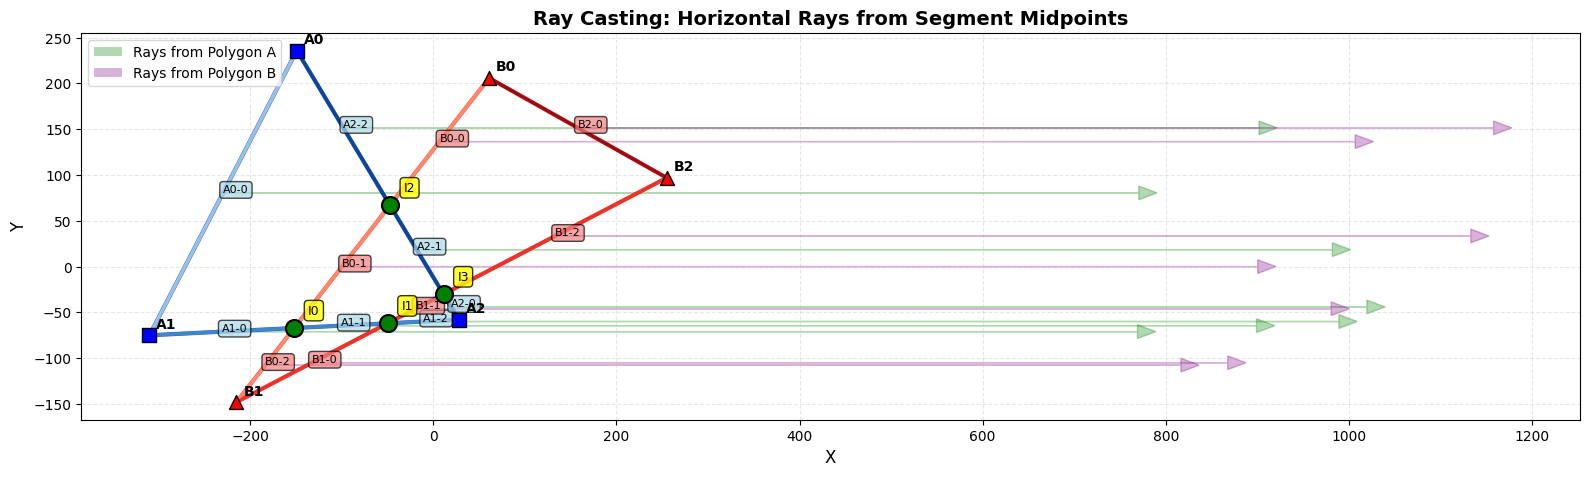

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_with_rays(poly1, poly2, seg1, seg2, intersections):
    """
    Visualize polygons, segments, and horizontal rays from midpoints
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    # Draw original polygon outlines
    poly1_x = [p[0] for p in poly1] + [poly1[0][0]]
    poly1_y = [p[1] for p in poly1] + [poly1[0][1]]
    ax.plot(poly1_x, poly1_y, 'b-', linewidth=3, label='Polygon A (outline)', alpha=0.7)
    
    poly2_x = [p[0] for p in poly2] + [poly2[0][0]]
    poly2_y = [p[1] for p in poly2] + [poly2[0][1]]
    ax.plot(poly2_x, poly2_y, 'r-', linewidth=3, label='Polygon B (outline)', alpha=0.7)
    
    # Color palette for segments
    colors_a = plt.cm.Blues(np.linspace(0.4, 0.9, len(seg1)))
    colors_b = plt.cm.Reds(np.linspace(0.4, 0.9, len(seg2)))
    
    # Draw segmented edges for Polygon A
    for edge_idx, edge_segments in enumerate(seg1):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_a[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw horizontal ray to the right
            ray_length = 1000  # extend far to the right
            ax.arrow(mid_x, mid_y, ray_length, 0, 
                    head_width=15, head_length=20, 
                    fc='green', ec='green', alpha=0.3, linewidth=1)
            
            # Label segment
            ax.annotate(f'A{edge_idx}-{seg_idx}', 
                       xy=(mid_x, mid_y), fontsize=8, 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightblue', alpha=0.7))
    
    # Draw segmented edges for Polygon B
    for edge_idx, edge_segments in enumerate(seg2):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_b[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw horizontal ray to the right
            ray_length = 1000
            ax.arrow(mid_x, mid_y, ray_length, 0, 
                    head_width=15, head_length=20, 
                    fc='purple', ec='purple', alpha=0.3, linewidth=1)
            
            # Label segment
            ax.annotate(f'B{edge_idx}-{seg_idx}', 
                       xy=(mid_x, mid_y), fontsize=8, 
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='lightcoral', alpha=0.7))
    
    # Draw intersection points
    if intersections:
        int_x = [p[0] for p in intersections]
        int_y = [p[1] for p in intersections]
        ax.scatter(int_x, int_y, c='green', s=150, zorder=5, 
                  label='Intersections', marker='o', edgecolors='black', linewidth=1.5)
        
        for i, (x, y) in enumerate(intersections):
            ax.annotate(f'I{i}', 
                       xy=(x, y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # Draw polygon vertices
    for i, p in enumerate(poly1):
        ax.scatter(p[0], p[1], c='blue', s=100, zorder=4, marker='s', edgecolors='black')
        ax.annotate(f'A{i}', xy=p, xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    for i, p in enumerate(poly2):
        ax.scatter(p[0], p[1], c='red', s=100, zorder=4, marker='^', edgecolors='black')
        ax.annotate(f'B{i}', xy=p, xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=10, ncol=2)
    ax.set_title('Ray Casting: Horizontal Rays from Segment Midpoints', fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Add custom legend for rays
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Rays from Polygon A'),
        Patch(facecolor='purple', alpha=0.3, label='Rays from Polygon B')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_with_rays(A, B, segments_poly1, segments_poly2, intersections)

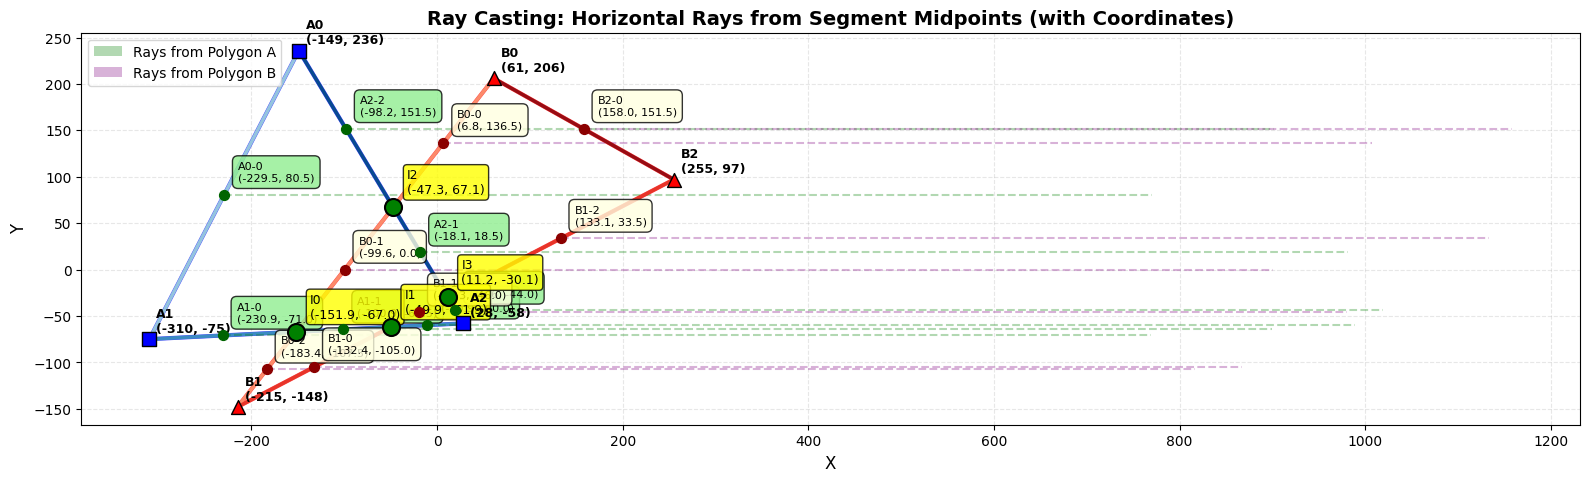

In [88]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_with_rays(poly1, poly2, seg1, seg2, intersections):
    """
    Visualize polygons, segments, and horizontal rays from midpoints with coordinates
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    # Draw original polygon outlines
    poly1_x = [p[0] for p in poly1] + [poly1[0][0]]
    poly1_y = [p[1] for p in poly1] + [poly1[0][1]]
    ax.plot(poly1_x, poly1_y, 'b-', linewidth=3, label='Polygon A (outline)', alpha=0.7)
    
    poly2_x = [p[0] for p in poly2] + [poly2[0][0]]
    poly2_y = [p[1] for p in poly2] + [poly2[0][1]]
    ax.plot(poly2_x, poly2_y, 'r-', linewidth=3, label='Polygon B (outline)', alpha=0.7)
    
    # Color palette for segments
    colors_a = plt.cm.Blues(np.linspace(0.4, 0.9, len(seg1)))
    colors_b = plt.cm.Reds(np.linspace(0.4, 0.9, len(seg2)))
    
    # Draw segmented edges for Polygon A
    for edge_idx, edge_segments in enumerate(seg1):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_a[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw midpoint as a dot
            ax.scatter(mid_x, mid_y, c='darkgreen', s=50, zorder=6, marker='o')
            
            # Draw horizontal ray to the right
            ray_length = 1000
            ax.plot([mid_x, mid_x + ray_length], [mid_y, mid_y], 
                   color='green', alpha=0.3, linewidth=1.5, linestyle='--')
            
            # Label segment with coordinates
            ax.annotate(f'A{edge_idx}-{seg_idx}\n({mid_x:.1f}, {mid_y:.1f})', 
                       xy=(mid_x, mid_y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    # Draw segmented edges for Polygon B
    for edge_idx, edge_segments in enumerate(seg2):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_b[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw midpoint as a dot
            ax.scatter(mid_x, mid_y, c='darkred', s=50, zorder=6, marker='o')
            
            # Draw horizontal ray to the right
            ray_length = 1000
            ax.plot([mid_x, mid_x + ray_length], [mid_y, mid_y], 
                   color='purple', alpha=0.3, linewidth=1.5, linestyle='--')
            
            # Label segment with coordinates
            ax.annotate(f'B{edge_idx}-{seg_idx}\n({mid_x:.1f}, {mid_y:.1f})', 
                       xy=(mid_x, mid_y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
    
    # Draw intersection points
    if intersections:
        int_x = [p[0] for p in intersections]
        int_y = [p[1] for p in intersections]
        ax.scatter(int_x, int_y, c='green', s=150, zorder=5, 
                  label='Intersections', marker='o', edgecolors='black', linewidth=1.5)
        
        for i, (x, y) in enumerate(intersections):
            ax.annotate(f'I{i}\n({x:.1f}, {y:.1f})', 
                       xy=(x, y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # Draw polygon vertices
    for i, p in enumerate(poly1):
        ax.scatter(p[0], p[1], c='blue', s=100, zorder=4, marker='s', edgecolors='black')
        ax.annotate(f'A{i}\n({p[0]:.0f}, {p[1]:.0f})', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=9, fontweight='bold')
    
    for i, p in enumerate(poly2):
        ax.scatter(p[0], p[1], c='red', s=100, zorder=4, marker='^', edgecolors='black')
        ax.annotate(f'B{i}\n({p[0]:.0f}, {p[1]:.0f})', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=9, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=10, ncol=2)
    ax.set_title('Ray Casting: Horizontal Rays from Segment Midpoints (with Coordinates)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Add custom legend for rays
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Rays from Polygon A'),
        Patch(facecolor='purple', alpha=0.3, label='Rays from Polygon B')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_with_rays(A, B, segments_poly1, segments_poly2, intersections)

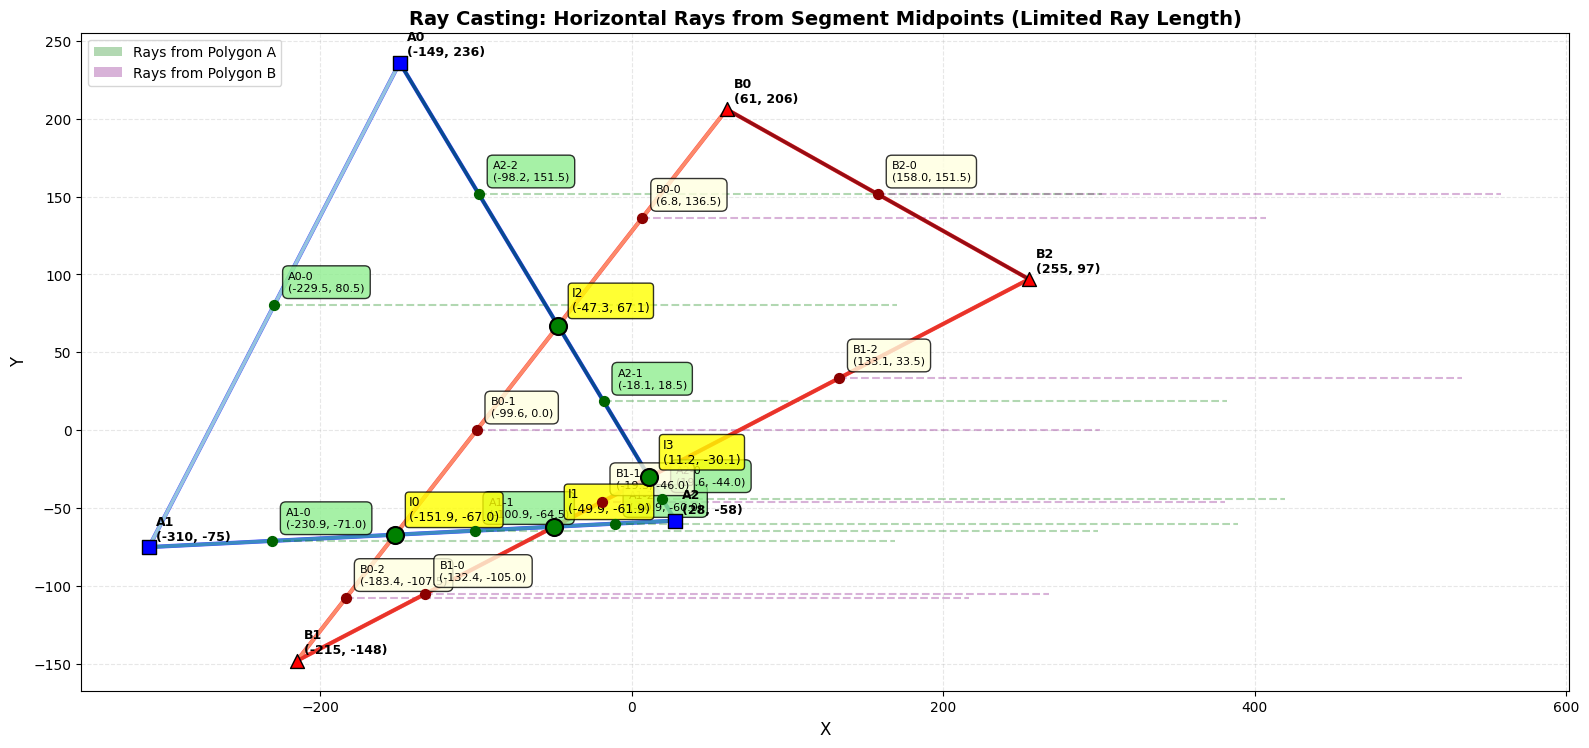

In [125]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_with_rays_and_counts(poly1, poly2, seg1, seg2, intersections):
    """
    Visualize polygons, segments, rays, and intersection counts
    """
    fig, ax = plt.subplots(1, 1, figsize=(16, 12))
    
    # Draw original polygon outlines
    poly1_x = [p[0] for p in poly1] + [poly1[0][0]]
    poly1_y = [p[1] for p in poly1] + [poly1[0][1]]
    ax.plot(poly1_x, poly1_y, 'b-', linewidth=3, label='Polygon A (outline)', alpha=0.7)
    
    poly2_x = [p[0] for p in poly2] + [poly2[0][0]]
    poly2_y = [p[1] for p in poly2] + [poly2[0][1]]
    ax.plot(poly2_x, poly2_y, 'r-', linewidth=3, label='Polygon B (outline)', alpha=0.7)
    
    # Color palette for segments
    colors_a = plt.cm.Blues(np.linspace(0.4, 0.9, len(seg1)))
    colors_b = plt.cm.Reds(np.linspace(0.4, 0.9, len(seg2)))
    
    ray_length = 400  # Limited ray length
    
    # Draw segmented edges for Polygon A
    for edge_idx, edge_segments in enumerate(seg1):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_a[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw midpoint as a dot
            ax.scatter(mid_x, mid_y, c='darkgreen', s=50, zorder=6, marker='o')
            
            # Draw horizontal ray to the right (limited length)
            ax.plot([mid_x, mid_x + ray_length], [mid_y, mid_y], 
                   color='green', alpha=0.3, linewidth=1.5, linestyle='--')
            
            # Label segment with coordinates and count
            ax.annotate(f'A{edge_idx}-{seg_idx}\n({mid_x:.1f}, {mid_y:.1f})', 
                       xy=(mid_x, mid_y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgreen', alpha=0.8))
    
    # Draw segmented edges for Polygon B
    for edge_idx, edge_segments in enumerate(seg2):
        for seg_idx, segment in enumerate(edge_segments):
            p1, p2 = segment
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   color=colors_b[edge_idx], linewidth=2.5)
            
            # Midpoint
            mid_x = (p1[0] + p2[0]) / 2
            mid_y = (p1[1] + p2[1]) / 2
            
            # Draw midpoint as a dot
            ax.scatter(mid_x, mid_y, c='darkred', s=50, zorder=6, marker='o')
            
            # Draw horizontal ray to the right (limited length)
            ax.plot([mid_x, mid_x + ray_length], [mid_y, mid_y], 
                   color='purple', alpha=0.3, linewidth=1.5, linestyle='--')
            
            # Label segment with coordinates
            ax.annotate(f'B{edge_idx}-{seg_idx}\n({mid_x:.1f}, {mid_y:.1f})', 
                       xy=(mid_x, mid_y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=8,
                       bbox=dict(boxstyle='round,pad=0.5', facecolor='lightyellow', alpha=0.8))
    
    # Draw intersection points
    if intersections:
        int_x = [p[0] for p in intersections]
        int_y = [p[1] for p in intersections]
        ax.scatter(int_x, int_y, c='green', s=150, zorder=5, 
                  label='Intersections', marker='o', edgecolors='black', linewidth=1.5)
        
        for i, (x, y) in enumerate(intersections):
            ax.annotate(f'I{i}\n({x:.1f}, {y:.1f})', 
                       xy=(x, y), xytext=(10, 10), 
                       textcoords='offset points', fontsize=9,
                       bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.8))
    
    # Draw polygon vertices
    for i, p in enumerate(poly1):
        ax.scatter(p[0], p[1], c='blue', s=100, zorder=4, marker='s', edgecolors='black')
        ax.annotate(f'A{i}\n({p[0]:.0f}, {p[1]:.0f})', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=9, fontweight='bold')
    
    for i, p in enumerate(poly2):
        ax.scatter(p[0], p[1], c='red', s=100, zorder=4, marker='^', edgecolors='black')
        ax.annotate(f'B{i}\n({p[0]:.0f}, {p[1]:.0f})', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=9, fontweight='bold')
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=10, ncol=2)
    ax.set_title('Ray Casting: Horizontal Rays from Segment Midpoints (Limited Ray Length)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    # Add custom legend for rays
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='green', alpha=0.3, label='Rays from Polygon A'),
        Patch(facecolor='purple', alpha=0.3, label='Rays from Polygon B')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    plt.tight_layout()
    plt.show()

# Run the visualization
visualize_with_rays_and_counts(A, B, segments_poly1, segments_poly2, intersections)

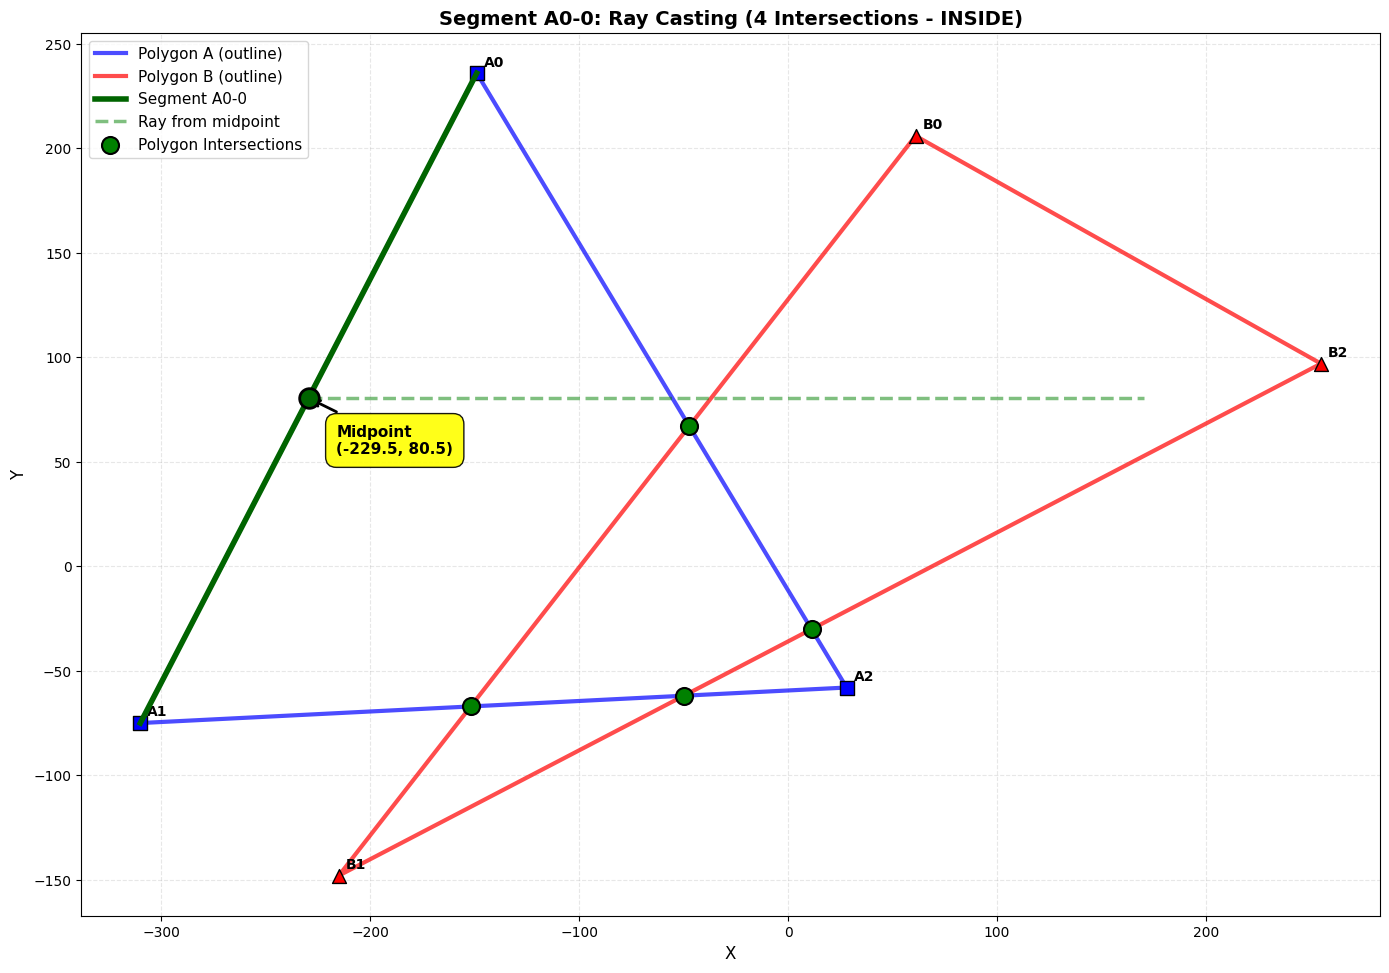

In [129]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_single_segment(poly1, poly2, seg1, intersections, edge_idx=0, seg_idx=0):
    """
    Visualize a single segment with its ray and intersection details
    """
    fig, ax = plt.subplots(1, 1, figsize=(14, 10))
    
    # Draw original polygon outlines
    poly1_x = [p[0] for p in poly1] + [poly1[0][0]]
    poly1_y = [p[1] for p in poly1] + [poly1[0][1]]
    ax.plot(poly1_x, poly1_y, 'b-', linewidth=3, label='Polygon A (outline)', alpha=0.7)
    
    poly2_x = [p[0] for p in poly2] + [poly2[0][0]]
    poly2_y = [p[1] for p in poly2] + [poly2[0][1]]
    ax.plot(poly2_x, poly2_y, 'r-', linewidth=3, label='Polygon B (outline)', alpha=0.7)
    
    # Get the specific segment
    segment = seg1[edge_idx][seg_idx]
    p1, p2 = segment
    
    # Draw the segment in bold
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
           color='darkgreen', linewidth=4, label=f'Segment A{edge_idx}-{seg_idx}', zorder=5)
    
    # Midpoint
    mid_x = (p1[0] + p2[0]) / 2
    mid_y = (p1[1] + p2[1]) / 2
    
    # Draw midpoint as a large dot
    ax.scatter(mid_x, mid_y, c='darkgreen', s=200, zorder=7, marker='o', edgecolors='black', linewidth=2)
    
    # Draw horizontal ray to the right
    ray_length = 400
    ax.plot([mid_x, mid_x + ray_length], [mid_y, mid_y], 
           color='green', alpha=0.5, linewidth=2.5, linestyle='--', label='Ray from midpoint', zorder=4)
    
    # Draw polygon vertices
    for i, p in enumerate(poly1):
        ax.scatter(p[0], p[1], c='blue', s=100, zorder=4, marker='s', edgecolors='black')
        ax.annotate(f'A{i}', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=10, fontweight='bold')
    
    for i, p in enumerate(poly2):
        ax.scatter(p[0], p[1], c='red', s=100, zorder=4, marker='^', edgecolors='black')
        ax.annotate(f'B{i}', xy=p, xytext=(5, 5), 
                   textcoords='offset points', fontsize=10, fontweight='bold')
    
    # Draw intersection points
    if intersections:
        int_x = [pt[0] for pt in intersections]
        int_y = [pt[1] for pt in intersections]
        ax.scatter(int_x, int_y, c='green', s=150, zorder=5, 
                  label='Polygon Intersections', marker='o', edgecolors='black', linewidth=1.5)
    
    # Add midpoint label with coordinates
    ax.annotate(f'Midpoint\n({mid_x:.1f}, {mid_y:.1f})', 
               xy=(mid_x, mid_y), xytext=(20, -40), 
               textcoords='offset points', fontsize=11, fontweight='bold',
               bbox=dict(boxstyle='round,pad=0.7', facecolor='yellow', alpha=0.9),
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))
    
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3, linestyle='--')
    ax.legend(loc='upper left', fontsize=11)
    ax.set_title(f'Segment A0-0: Ray Casting (4 Intersections - INSIDE)', 
                fontsize=14, fontweight='bold')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# Run the visualization for A0-0
visualize_single_segment(A, B, segments_poly1, intersections, edge_idx=0, seg_idx=0)